Listwise recomentation using DDPG
* Paper https://arxiv.org/pdf/1801.00209.pdf
* Code reference for original paper https://github.com/luozachary/drl-rec/blob/master/build_estimator.py
* Code in this implementation kept the DDPG Actor-Critic frame work, but the neural network framework as been simplified to reduce training time. Added deep and wide style state representation. Also, pytorch was used instead of tensorflow. 

In [24]:
from collections import defaultdict
import os
import pickle
import random
import requests
import time
import tqdm
import scipy
import scipy.sparse as sp
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import torch_optimizer as optim
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td
from utils import Prioritized_Buffer

## 0. Data Preprocess

In [5]:
with open('../data/all_session_skips_train.pkl','rb') as f:
    skips_train = pickle.load(f)
with open('../data/all_session_skips_test.pkl','rb') as f:
    skips_test = pickle.load(f)
with open('../data/all_session_tracks_train.pkl','rb') as f:
    tracks_train = pickle.load(f)
with open('../data/all_session_tracks_test.pkl','rb') as f:
    tracks_test = pickle.load(f)

In [20]:
# Re-split train test by adding the first 10 tracks of test set into train data. 
max_train = 10000 # len(tracks_train)
max_test = 1000
train_data = []
test_data = []
for i in range(max_train):
    for j, track in enumerate(tracks_train[i]): 
        train_data.append([i,track ])
        
for i in range(max_test):
    for j, track in enumerate(tracks_test[i]): 
        if j<10:
            train_data.append([max_train+i,track])
        else:
            break
for i in range(max_test):
    for j, track in enumerate(tracks_test[i]): 
        if j>=10:
            test_data.append([i,track])
        else:
            pass
print(np.array(train_data).shape, np.array(test_data).shape)

(210000, 2) (10000, 2)


In [53]:
train_data[:10]

[[0, 1832],
 [0, 58552],
 [0, 102419],
 [0, 14626],
 [0, 40903],
 [0, 81105],
 [0, 91767],
 [0, 4904],
 [0, 98922],
 [0, 17561]]

In [54]:
test_data[:10]

[[0, 21471],
 [0, 68649],
 [0, 41459],
 [0, 83707],
 [0, 67462],
 [0, 93858],
 [0, 86293],
 [0, 74387],
 [0, 14816],
 [0, 102419]]

In [30]:
user_num = np.array(train_data)[:,0].max() + 1
item_num = np.array(train_data)[:,1].max() + 1

train_mat = defaultdict(int)
test_mat = defaultdict(int)
for user, item in train_data:
    train_mat[user, item] = 1
for user, item in test_data:
    test_mat[user, item] = 1
train_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(train_matrix, train_mat)
test_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(test_matrix, test_mat)

print(train_matrix.shape, test_matrix.shape)

(11000, 103909) (11000, 103909)


## 1. Evaluation data

In [31]:
# Prepare data for test
class BatchLoader(td.Dataset):
    def __init__(self, positive_data, item_num, data_mat, negative_samples=99):
        super(BatchLoader, self).__init__()
        self.positive_data = np.array(positive_data)
        self.item_num = item_num
        self.data_mat = data_mat
        self.negative_samples = negative_samples
        self.reset()
        
    def reset(self):
        print("Resetting test dataset")
        valid_data = []
        for user, positive in self.positive_data:
            valid_data.append([user, positive])
            # for seq recomendation only. 
            for i in range(self.negative_samples):
                negative = np.random.randint(self.item_num)
                while (user, negative) in self.data_mat:
                    negative = np.random.randint(self.item_num)
                valid_data.append([user, negative])
        labels = np.zeros(len(self.positive_data) * (1 + self.negative_samples))
        labels[::1+self.negative_samples] = 1
        self.data = np.concatenate([
            np.array(valid_data), 
            np.array(labels)[:, np.newaxis]], 
            axis=1
        )
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        output = {
            "user": user,
            "track": item,
            "label": np.float32(label),
        }
        return output

valid_dataset = BatchLoader(
    np.array(test_data), 
    item_num, 
    test_matrix)
valid_loader = td.DataLoader(valid_dataset, batch_size=100, shuffle=False)

Resetting test dataset


In [32]:
# Define evaluation metric
def to_np(tensor):
    return tensor.detach().cpu().numpy()

def hit_metric(recommended, actual):
    return int(actual in recommended)

def dcg_metric(recommended, actual):
    if actual in recommended:
        index = recommended.index(actual)
        return np.reciprocal(np.log2(index + 2))
    return 0

def aa(pred, act, k=10):
    L = 1.0*(np.array(pred) == np.array(act))
    A = np.zeros(k)
    for i in range(k):
        A[i] = np.mean(L[0:i+1])
    AA = np.sum(A*L) / k
    return AA

def run_evaluation(net, states, train_memory, loader=valid_loader):
    hits = []
    dcgs = []
    aa_1=[]
    aa_10=[]
    test_env = Env(test_matrix)
    test_env.memory = train_memory.copy()
    user, memory = test_env.reset(int(to_np(next(iter(valid_loader))['user'])[0]))
    for batch in loader:
        action_emb = net(state_repr(user, memory))
        scores, action = net.get_action(
            batch['user'], 
            torch.tensor(test_env.memory[to_np(batch['user']).astype(int), :]), 
            states, 
            action_emb,
            batch['track'].long(), 
            return_scores=True
        )
        user, memory, reward, done = test_env.step(action)

        _, ind = scores[:, 0].topk(10)
        predictions = torch.take(batch['track'], ind).cpu().numpy().tolist()
        actuals=batch['track'][:10]
        
#         import pdb; pdb.set_trace()
        actual_1 = batch['track'][0].item()
        hits.append(hit_metric(predictions, actual_1))
        dcgs.append(dcg_metric(predictions, actual_1))

        aa_1.append(aa(predictions, actuals, 1))
        aa_10.append(aa(predictions, actuals, 10))
        
    return np.mean(hits), np.mean(dcgs), np.mean(aa_1), np.mean(aa_10)

## 3. Model

In [33]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16

In [37]:
class Env():
    def __init__(self, user_item_matrix):
        self.matrix = user_item_matrix
        self.item_count = item_num
        self.memory = np.ones([user_num, 5]) * item_num

    def reset(self, user_id):
        self.user_id = user_id
        self.viewed_items = [] #keep track of what track has been listened
        self.related_items = np.argwhere(self.matrix[self.user_id] > 0)[:, 1]
        self.num_rele = len(self.related_items)
        # choose a new item
        self.nonrelated_items = np.random.choice(
            list(set(range(self.item_count)) - set(self.related_items)), self.num_rele)
        self.candidates = np.zeros(self.num_rele * 2)
        self.candidates[::2] = self.related_items
        self.candidates[1::2] = self.nonrelated_items
        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :])
    
    def step(self, action, action_emb=None, buffer=None):
        reward = float(to_np(action)[0] in self.related_items)
        self.viewed_items.append(to_np(action)[0])
        if reward:
            if len(action) == 1:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action]
            else:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action[0]]
                
        if len(self.viewed_items) == len(self.related_items):
            done = 1
        else:
            done = 0
            
        if buffer is not None:
            buffer.push(np.array([self.user_id]), np.array(self.memory[[self.user_id], :]), to_np(action_emb)[0], 
                        np.array([reward]), np.array([self.user_id]), self.memory[[self.user_id], :], np.array([reward]))

        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :]), reward, done

class Actor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
            # Note the original paper implemented an RNN unit here
        )
        self.initialize()

    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)

    def forward(self, state):
        return self.layers(state)
    
    def get_action(self, user, memory, state_repr, 
                   action_emb,
                   items=torch.tensor([i for i in range(item_num)]),
                   return_scores=False
                  ):
        state = state_repr(user, memory)
        #dot product state and action
        scores = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0), 
                           action_emb.T.unsqueeze(0)
                          ).squeeze(0)
        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0))
        else:
            return torch.gather(items, 0, scores.argmax(0))

class Critic(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
            # Note the original paper implemented an RNN unit here
        )
        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x

class State(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num+1, embedding_dim, padding_idx=int(item_num))
        self.initialize()

    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()

    def forward(self, user, memory):
        user_embedding = self.user_embeddings(user.long())
        item_embeddings = self.item_embeddings(memory.long())
        item_ave = torch.sum(item_embeddings, dim=1)
        # user state represented as user_embedding, item_userviewed, and the product of the 2, as in deep and wide recomendation
        return torch.cat((user_embedding, user_embedding * item_ave, item_ave), 1)

# training
torch.manual_seed(2)

state_repr = State(user_num, item_num, EMBEDDING_SIZE, HIDDEN_SIZE)
policy = Actor(EMBEDDING_SIZE, HIDDEN_SIZE)
value_net  = Critic(EMBEDDING_SIZE * 3, EMBEDDING_SIZE, HIDDEN_SIZE)
replay_buffer = Prioritized_Buffer(10000)

target_value_net  = Critic(EMBEDDING_SIZE * 3, EMBEDDING_SIZE, HIDDEN_SIZE)
target_policy = Actor(EMBEDDING_SIZE, HIDDEN_SIZE)

value_criterion  = nn.MSELoss()
value_optimizer  = optim.Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer = optim.Ranger(policy.parameters(), lr=1e-4)
state_repr_optimizer = optim.Ranger(state_repr.parameters(), lr=1e-4)


def update(training_env, 
                step=0,
                batch_size=512, 
                gamma=0.9,
               ):
    beta = min(1.0, 0.4 + step * (1.0 - 0.4) / 1000)
    u, m, a, r, nu, nm, done = replay_buffer.sample(batch_size, beta)
    user        = torch.FloatTensor(u)
    memory      = torch.FloatTensor(m)
    action      = torch.FloatTensor(a)
    reward      = torch.FloatTensor(r)
    next_user   = torch.FloatTensor(nu)
    next_memory = torch.FloatTensor(nm)

    done = torch.FloatTensor(done)
    
    state       = state_repr(user, memory)
    policy_loss = -value_net(state, policy(state)).mean()
    
    next_state     = state_repr(next_user, next_memory)
    next_action    = target_policy(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    state_repr_optimizer.zero_grad()
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()
    state_repr_optimizer.step()


np.random.seed(1234)
train_env = Env(train_matrix)
dcgs_all, maa_all = [], []


episode = 0
users = np.arange(1000) 

for u in tqdm.tqdm(users):
    user, memory = train_env.reset(u)
    for t in range(int(train_matrix[u].sum())):
        action_emb = policy(state_repr(user, memory))
        action = policy.get_action(
            user, 
            torch.tensor(train_env.memory[to_np(user).astype(int), :]), 
            state_repr, 
            action_emb,
            torch.tensor(
                [item for item in train_env.candidates 
                if item not in train_env.viewed_items]
            ).long()
        )
        user, memory, reward, done = train_env.step(
            action, 
            action_emb,
            buffer=replay_buffer
        )

        if len(replay_buffer) > 512: #batch_size
            update(train_env, step=episode)

        if episode%10 ==0:
            hit, dcg, aa1, aa10 = run_evaluation(policy, state_repr, train_env.memory)
            print(hit, dcg, aa1, aa10)
            dcgs_all.append(dcg), maa_all.append(aa10)

        episode += 1


  0%|          | 0/1000 [00:00<?, ?it/s]

0.1022 0.04483705849050198 0.008 0.002784936507936508


  0%|          | 1/1000 [00:18<5:05:02, 18.32s/it]

0.1051 0.0459760847808076 0.008 0.0028074126984126983
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  0%|          | 2/1000 [00:36<5:04:48, 18.33s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  0%|          | 3/1000 [00:54<5:04:26, 18.32s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873


  0%|          | 4/1000 [01:04<4:18:42, 15.59s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  0%|          | 5/1000 [01:22<4:32:00, 16.40s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|          | 6/1000 [01:40<4:41:12, 16.97s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|          | 7/1000 [01:59<4:47:38, 17.38s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|          | 8/1000 [02:17<4:51:56, 17.66s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|          | 9/1000 [02:35<4:54:56, 17.86s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|          | 10/1000 [02:44<4:11:42, 15.26s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|          | 11/1000 [03:03<4:26:32, 16.17s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|          | 12/1000 [03:21<4:36:46, 16.81s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|▏         | 13/1000 [03:30<3:58:56, 14.52s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  1%|▏         | 14/1000 [03:49<4:17:18, 15.66s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 15/1000 [04:07<4:30:03, 16.45s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 16/1000 [04:25<4:38:47, 17.00s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 17/1000 [04:43<4:44:38, 17.37s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 18/1000 [05:02<4:48:44, 17.64s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 19/1000 [05:20<4:51:46, 17.85s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 20/1000 [05:29<4:09:08, 15.25s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 21/1000 [05:48<4:24:03, 16.18s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 23/1000 [06:06<3:12:11, 11.80s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▏         | 24/1000 [06:15<2:59:07, 11.01s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  2%|▎         | 25/1000 [06:33<3:34:16, 13.19s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  3%|▎         | 26/1000 [06:52<3:59:15, 14.74s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  3%|▎         | 27/1000 [07:10<4:16:14, 15.80s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


  3%|▎         | 28/1000 [07:28<4:27:29, 16.51s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873


  3%|▎         | 29/1000 [07:37<3:51:10, 14.28s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.048204707949700276 0.0106 0.00290815873015873


/home/tianyuancui/anaconda3/envs/cs7643-a2/lib/python3.8/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
  3%|▎         | 30/1000 [07:55<4:09:33, 15.44s/it]

0.1071 0.048204707949700276 0.0106 0.00290815873015873
0.1071 0.04820365733274335 0.0105 0.002890777777777778


  3%|▎         | 31/1000 [08:14<4:24:11, 16.36s/it]

0.1072 0.04824767146783542 0.0105 0.002897960317460318
0.1072 0.04830758628779745 0.0108 0.0028862261904761904


  3%|▎         | 32/1000 [08:32<4:32:50, 16.91s/it]

0.1071 0.04828125201928689 0.0105 0.0029124246031746034
0.1068 0.04816153467857918 0.0104 0.0029056309523809525


  3%|▎         | 33/1000 [08:50<4:39:48, 17.36s/it]

0.1068 0.04818978085627999 0.0104 0.002927043650793651
0.1069 0.04829924464532798 0.0107 0.002936353174603175


  3%|▎         | 34/1000 [09:09<4:44:43, 17.68s/it]

0.1068 0.048281851895695255 0.0106 0.0029292222222222224
0.1066 0.048357778202788713 0.0109 0.0029574007936507937


  4%|▎         | 35/1000 [09:27<4:46:10, 17.79s/it]

0.1063 0.04826570125974721 0.0108 0.002924178571428571


  4%|▎         | 36/1000 [09:36<4:04:34, 15.22s/it]

0.1063 0.048289870195718496 0.0106 0.0029016785714285715
0.1062 0.04828670882172883 0.0106 0.002914575396825397


  4%|▎         | 37/1000 [09:54<4:18:15, 16.09s/it]

0.1062 0.04828680781577616 0.0106 0.002938400793650794
0.1059 0.04823253992569875 0.0107 0.0029341309523809524


  4%|▍         | 38/1000 [10:13<4:28:45, 16.76s/it]

0.1058 0.04814252097240975 0.0106 0.0028893531746031747


  4%|▍         | 39/1000 [10:22<3:53:19, 14.57s/it]

0.1061 0.0482088037053466 0.0107 0.0029083373015873016
0.1061 0.04816241199416646 0.0106 0.0029275238095238095


  4%|▍         | 40/1000 [10:41<4:11:56, 15.75s/it]

0.1063 0.04828482515637539 0.0108 0.002955761904761905
0.1062 0.04824954361962846 0.0108 0.00296559126984127


  4%|▍         | 41/1000 [10:59<4:23:54, 16.51s/it]

0.1062 0.04827711667663527 0.0108 0.0029382738095238095
0.1065 0.04841685684759012 0.0109 0.0029629087301587297


  4%|▍         | 42/1000 [11:17<4:31:41, 17.02s/it]

0.1067 0.048474324004314534 0.011 0.003003678571428571


  4%|▍         | 43/1000 [11:26<3:55:03, 14.74s/it]

0.1063 0.048364350101161836 0.0111 0.0030164563492063494
0.1063 0.048308061464438244 0.0109 0.003000829365079365


  4%|▍         | 44/1000 [11:45<4:11:53, 15.81s/it]

0.1064 0.048367555873805396 0.0109 0.002999373015873016
0.1062 0.0482789911617247 0.0111 0.0030475000000000003


  4%|▍         | 45/1000 [12:03<4:24:27, 16.62s/it]

0.1055 0.04805948909519165 0.0111 0.0030480674603174606
0.1055 0.048130139864784566 0.0112 0.0030575833333333336


  5%|▍         | 46/1000 [12:22<4:32:09, 17.12s/it]

0.1055 0.048058256019660975 0.0111 0.003031964285714286
0.1044 0.04698672071870497 0.0107 0.0029226706349206348
0.1041 0.04687723147694638 0.0107 0.0029304166666666667


  5%|▍         | 47/1000 [12:40<4:39:53, 17.62s/it]

0.103 0.04643439066450107 0.0106 0.0029274325396825398


  5%|▍         | 48/1000 [12:59<4:42:59, 17.84s/it]

0.1023 0.04606820173744558 0.0102 0.002898686507936508
0.1018 0.045845653812770136 0.0101 0.002882777777777778


  5%|▍         | 49/1000 [13:17<4:44:27, 17.95s/it]

0.1014 0.045745812691663265 0.0103 0.00291275
0.1011 0.045716892626634774 0.0109 0.003013936507936508


  5%|▌         | 50/1000 [13:35<4:46:03, 18.07s/it]

0.1001 0.04537999778898816 0.011 0.0030146904761904764
0.0997 0.045247198803513154 0.0112 0.0030713095238095235


  5%|▌         | 51/1000 [13:54<4:47:52, 18.20s/it]

0.0993 0.04503606547999746 0.0114 0.0030882380952380953
0.0983 0.0446947202446418 0.0116 0.003087734126984127


  5%|▌         | 52/1000 [14:12<4:47:40, 18.21s/it]

0.0973 0.044320080071982876 0.0116 0.003109039682539683
0.0948 0.0432613114372487 0.011 0.003036412698412699


  5%|▌         | 53/1000 [14:30<4:47:17, 18.20s/it]

0.0946 0.04307532564015112 0.0111 0.0030907738095238097
0.0942 0.04289425774251077 0.0112 0.003114345238095238


  5%|▌         | 54/1000 [14:48<4:46:30, 18.17s/it]

0.0929 0.042472749441403036 0.011 0.003107190476190476
0.092 0.04209505609912375 0.0109 0.0030855079365079362


  6%|▌         | 55/1000 [15:06<4:46:07, 18.17s/it]

0.0914 0.04189717924425038 0.0109 0.003031654761904762
0.0907 0.04142329819354032 0.0102 0.0029714642857142856


  6%|▌         | 56/1000 [15:16<4:05:02, 15.57s/it]

0.0891 0.04085876575702727 0.0104 0.00297952380952381


  6%|▌         | 57/1000 [15:34<4:17:12, 16.37s/it]

0.088 0.040483959569643777 0.0102 0.0029973531746031747
0.0867 0.040029927135960076 0.0103 0.003007968253968254


  6%|▌         | 58/1000 [15:52<4:25:38, 16.92s/it]

0.0861 0.039747837199977036 0.0098 0.002950222222222222


  6%|▌         | 59/1000 [16:02<3:49:50, 14.66s/it]

0.0858 0.039569699395777286 0.0099 0.0029181507936507935
0.0848 0.03908496671253512 0.0099 0.002894706349206349


  6%|▌         | 60/1000 [16:20<4:07:11, 15.78s/it]

0.0847 0.03893649128751081 0.0095 0.0028613373015873014


  6%|▌         | 61/1000 [16:29<3:36:15, 13.82s/it]

0.0843 0.03866414190518781 0.0095 0.002855261904761905
0.0836 0.038103901641988715 0.0091 0.0027947341269841273


  6%|▌         | 62/1000 [16:48<3:57:54, 15.22s/it]

0.083 0.0378627345632295 0.0092 0.0028310158730158732
0.0833 0.03776335069522163 0.0087 0.0028173730158730158


  6%|▋         | 63/1000 [17:06<4:11:33, 16.11s/it]

0.0823 0.0372094008723908 0.0084 0.0027923650793650794
0.0813 0.03674719982951473 0.0083 0.0027794920634920638


  6%|▋         | 64/1000 [17:24<4:21:30, 16.76s/it]

0.0799 0.036271878218687235 0.0084 0.0028197182539682537
0.0785 0.035726579524230945 0.0082 0.0027525119047619047


  6%|▋         | 65/1000 [17:43<4:28:52, 17.25s/it]

0.0772 0.035313131205407265 0.0083 0.0027584920634920636
0.0762 0.03489327576170637 0.0082 0.0027454126984126984


  7%|▋         | 66/1000 [18:01<4:33:22, 17.56s/it]

0.0757 0.03452509419379924 0.008 0.00271831746031746
0.0751 0.03429409386479806 0.0078 0.002734638888888889


  7%|▋         | 67/1000 [18:11<3:55:35, 15.15s/it]

0.0746 0.03411416599128065 0.0077 0.002727039682539683
0.074 0.033791463287884516 0.0076 0.0027121190476190474


  7%|▋         | 68/1000 [18:29<4:11:27, 16.19s/it]

0.0735 0.03360843637643871 0.0077 0.0027425714285714284


  7%|▋         | 69/1000 [18:47<4:20:25, 16.78s/it]

0.0727 0.033272645463454355 0.0077 0.0027165753968253973
0.072 0.032861418205296665 0.0073 0.0027103333333333337


  7%|▋         | 70/1000 [19:06<4:26:38, 17.20s/it]

0.0712 0.03259053334885565 0.0073 0.0027431349206349207
0.071 0.0325338308071292 0.0074 0.0027695555555555555


  7%|▋         | 71/1000 [19:24<4:31:37, 17.54s/it]

0.0694 0.0319464867457154 0.0075 0.0027832738095238097
0.0689 0.03171751230218127 0.0075 0.0027696468253968257


  7%|▋         | 72/1000 [19:42<4:34:52, 17.77s/it]

0.0679 0.031398538726163716 0.0078 0.0027975039682539686
0.0668 0.030990773112329423 0.0077 0.002814019841269841


  7%|▋         | 73/1000 [20:01<4:37:19, 17.95s/it]

0.0665 0.0307689225605864 0.0074 0.0027923492063492063
0.0665 0.030699993993255542 0.0073 0.002802103174603175


  7%|▋         | 74/1000 [20:19<4:39:51, 18.13s/it]

0.0662 0.03022939937517693 0.0067 0.002710373015873016
0.0659 0.03007714320446998 0.0068 0.002705238095238095


  8%|▊         | 75/1000 [20:37<4:39:51, 18.15s/it]

0.0654 0.029702339510003797 0.0063 0.0026784642857142858
0.0651 0.02952369287441876 0.0067 0.0027094960317460316


  8%|▊         | 76/1000 [20:56<4:40:14, 18.20s/it]

0.0649 0.029479438696732762 0.007 0.002670952380952381


  8%|▊         | 77/1000 [21:05<3:58:12, 15.48s/it]

0.0643 0.029221194116432606 0.007 0.0026256190476190476
0.0634 0.028837616229740293 0.0071 0.00258534126984127


  8%|▊         | 78/1000 [21:23<4:10:10, 16.28s/it]

0.0628 0.028618232582735284 0.0068 0.0025571904761904764


  8%|▊         | 79/1000 [21:32<3:38:17, 14.22s/it]

0.0622 0.02838294613575732 0.0066 0.00253027380952381
0.062 0.028189968602391455 0.0064 0.002574230158730159


  8%|▊         | 80/1000 [21:51<3:58:15, 15.54s/it]

0.0615 0.028024905457174547 0.0067 0.0026186031746031745


  8%|▊         | 81/1000 [22:00<3:29:17, 13.66s/it]

0.0614 0.027950012547392405 0.0066 0.0026011984126984126
0.0607 0.027614157161448907 0.0062 0.002610186507936508


  8%|▊         | 82/1000 [22:19<3:50:34, 15.07s/it]

0.0603 0.027438150176719193 0.006 0.0026068214285714293
0.0602 0.027297895496148975 0.0059 0.002629496031746032


  8%|▊         | 83/1000 [22:37<4:06:07, 16.10s/it]

0.0607 0.027350223411578663 0.0059 0.0026365198412698415
0.0606 0.027107177352885377 0.0057 0.002599996031746032


  8%|▊         | 84/1000 [22:55<4:16:25, 16.80s/it]

0.0607 0.027074595459090467 0.0056 0.002522210317460317
0.0603 0.026869036594162794 0.006 0.002564777777777778


  8%|▊         | 85/1000 [23:05<3:43:02, 14.63s/it]

0.0599 0.026659625855065667 0.0061 0.002572702380952381
0.0597 0.02659334619820437 0.0061 0.0025565912698412704


  9%|▊         | 86/1000 [23:23<4:00:10, 15.77s/it]

0.0594 0.02646250911456486 0.006 0.002563829365079365


  9%|▊         | 87/1000 [23:42<4:11:13, 16.51s/it]

0.0592 0.026391335317266503 0.0061 0.0025473769841269844
0.0592 0.026433855507533847 0.0061 0.002565575396825397


  9%|▉         | 88/1000 [24:00<4:19:25, 17.07s/it]

0.059 0.02639184511122346 0.0064 0.002618301587301587


  9%|▉         | 89/1000 [24:10<3:44:24, 14.78s/it]

0.0589 0.026311884237013874 0.0064 0.002602202380952381
0.0587 0.02636608404856462 0.0067 0.0026142817460317463


  9%|▉         | 90/1000 [24:28<4:00:07, 15.83s/it]

0.0585 0.02631695761156482 0.0066 0.0025715
0.0585 0.026274833741909073 0.0065 0.0025530515873015873


  9%|▉         | 91/1000 [24:46<4:11:27, 16.60s/it]

0.0579 0.026073015535144985 0.0062 0.0025703055555555553
0.0574 0.025915024273590093 0.0065 0.0025125039682539685


  9%|▉         | 92/1000 [25:05<4:19:23, 17.14s/it]

0.057 0.025782844100927037 0.0064 0.0024923928571428566
0.0573 0.025874172529426125 0.0063 0.002505511904761905


  9%|▉         | 93/1000 [25:23<4:24:42, 17.51s/it]

0.0577 0.026002467810629103 0.0064 0.0025314365079365077
0.0579 0.02613541729196363 0.0065 0.002537611111111111


  9%|▉         | 94/1000 [25:41<4:28:40, 17.79s/it]

0.0574 0.025980049483166068 0.0065 0.0025469801587301587
0.0576 0.026068187674611557 0.0066 0.0025250238095238095


 10%|▉         | 95/1000 [26:00<4:30:53, 17.96s/it]

0.0576 0.026082729601687886 0.0066 0.0025468690476190474
0.0577 0.02612168789712108 0.0066 0.0025699642857142857


 10%|▉         | 96/1000 [26:18<4:32:42, 18.10s/it]

0.0583 0.026282891795870258 0.0066 0.0025868333333333338
0.0589 0.02644901906879111 0.0066 0.00257790873015873


 10%|▉         | 97/1000 [26:36<4:33:06, 18.15s/it]

0.0586 0.026384667658031116 0.0066 0.0025473769841269844
0.0585 0.02645979723218303 0.0069 0.002583349206349207


 10%|▉         | 98/1000 [26:55<4:34:00, 18.23s/it]

0.0578 0.026250575053625373 0.0067 0.0025424484126984124


 10%|▉         | 99/1000 [27:04<3:53:18, 15.54s/it]

0.0572 0.026089137839136925 0.0066 0.0025452698412698413
0.0576 0.02617371509348394 0.0067 0.002611452380952381


 10%|█         | 100/1000 [27:23<4:06:13, 16.41s/it]

0.0577 0.026205100231927504 0.0067 0.0025803809523809525
0.0583 0.026405686635224464 0.0068 0.002572765873015873


 10%|█         | 101/1000 [27:41<4:14:35, 16.99s/it]

0.0588 0.026510197920246118 0.0068 0.002572670634920635
0.0588 0.026472430527338213 0.0067 0.002564686507936508


 10%|█         | 102/1000 [27:59<4:20:36, 17.41s/it]

0.0589 0.02652714857789441 0.0068 0.0025528214285714286
0.0592 0.02661340563912685 0.0067 0.002554916666666667


 10%|█         | 103/1000 [28:18<4:25:18, 17.75s/it]

0.0595 0.026667182903476954 0.0065 0.0025131507936507935


 10%|█         | 104/1000 [28:18<3:06:48, 12.51s/it]

0.0595 0.02675013687398406 0.0065 0.00251202380952381


 10%|█         | 105/1000 [28:37<3:33:02, 14.28s/it]

0.0598 0.02685301148601337 0.0066 0.002520376984126984
0.0598 0.0269068631949365 0.0067 0.0025579047619047617


 11%|█         | 106/1000 [28:55<3:51:25, 15.53s/it]

0.0596 0.02695898327037587 0.007 0.002614107142857143
0.0596 0.0270050125116485 0.0071 0.0026053650793650793


 11%|█         | 107/1000 [29:13<4:04:07, 16.40s/it]

0.0595 0.027009806119349538 0.0071 0.0026102936507936504
0.0596 0.027053379198102006 0.0073 0.002588619047619048


 11%|█         | 108/1000 [29:32<4:13:31, 17.05s/it]

0.0601 0.02724078160714555 0.0074 0.002615166666666667


 11%|█         | 109/1000 [29:41<3:39:10, 14.76s/it]

0.0603 0.02730012733173877 0.0074 0.0026224047619047616
0.06 0.027227008016974724 0.0074 0.0026626150793650797


 11%|█         | 110/1000 [30:00<3:54:43, 15.82s/it]

0.0601 0.027253861355849732 0.0074 0.0026565992063492068
0.0601 0.027171632944140423 0.0073 0.002644730158730159


 11%|█         | 111/1000 [30:18<4:06:15, 16.62s/it]

0.0598 0.027056997919457787 0.0072 0.0026350952380952385
0.0598 0.027007119725355425 0.0072 0.002634234126984127


 11%|█         | 112/1000 [30:37<4:14:02, 17.16s/it]

0.0596 0.026900730555098864 0.0073 0.0026537420634920638
0.06 0.02704951303584204 0.0073 0.0026644603174603176


 11%|█▏        | 113/1000 [30:55<4:18:41, 17.50s/it]

0.0597 0.026942466344653797 0.0072 0.0027096746031746036
0.0599 0.026993509117630713 0.0071 0.0027213134920634923


 11%|█▏        | 114/1000 [31:13<4:22:16, 17.76s/it]

0.0603 0.02703141913696179 0.0069 0.0027120039682539685
0.06 0.0269600960745049 0.0068 0.0026635317460317457


 12%|█▏        | 115/1000 [31:32<4:25:07, 17.97s/it]

0.0598 0.026883956817871528 0.0069 0.002675015873015873
0.0599 0.02685061065884307 0.0068 0.0026716626984126983


 12%|█▏        | 116/1000 [31:51<4:28:50, 18.25s/it]

0.0592 0.02668524135936309 0.0068 0.002712833333333333
0.0594 0.02674787076574371 0.0068 0.0026925357142857146


 12%|█▏        | 117/1000 [32:10<4:31:55, 18.48s/it]

0.0596 0.026813093944298202 0.0067 0.0026884285714285716
0.0591 0.02667668576642165 0.0068 0.002720170634920635


 12%|█▏        | 118/1000 [32:29<4:35:26, 18.74s/it]

0.059 0.026646256592431267 0.0068 0.002715623015873016
0.0592 0.0266931631673547 0.0068 0.0027045793650793647


 12%|█▏        | 119/1000 [32:48<4:36:22, 18.82s/it]

0.0593 0.026696573519135763 0.0067 0.002704777777777778
0.0595 0.026721041033811538 0.0066 0.00268943253968254


 12%|█▏        | 120/1000 [33:07<4:37:29, 18.92s/it]

0.0594 0.02665282296352467 0.0066 0.0026990436507936507
0.0593 0.02662373889510458 0.0064 0.002652325396825397


 12%|█▏        | 121/1000 [33:17<3:58:28, 16.28s/it]

0.0589 0.0264923357554964 0.0064 0.002664238095238095
0.0586 0.026370361617057272 0.0063 0.002631503968253968


 12%|█▏        | 122/1000 [33:36<4:10:34, 17.12s/it]

0.0583 0.02630867721231982 0.0064 0.0026656428571428573


 12%|█▏        | 123/1000 [33:46<3:37:54, 14.91s/it]

0.0583 0.026295124799949905 0.0064 0.0026620198412698414
0.0582 0.02631554498286155 0.0065 0.0026692738095238097


 12%|█▏        | 124/1000 [34:05<3:55:34, 16.14s/it]

0.0579 0.026242718660803417 0.0066 0.0026508253968253966
0.0578 0.02620779127522925 0.0066 0.0026361071428571427


 12%|█▎        | 125/1000 [34:24<4:08:38, 17.05s/it]

0.058 0.026259210739884964 0.0067 0.002637246031746032


 13%|█▎        | 126/1000 [34:43<4:16:48, 17.63s/it]

0.058 0.02626881195218832 0.0067 0.002640690476190476
0.0579 0.02624210390369868 0.0068 0.002641357142857143


 13%|█▎        | 127/1000 [34:53<3:42:13, 15.27s/it]

0.0579 0.026250778240869455 0.0068 0.0026251507936507937
0.0576 0.026193827271512628 0.0067 0.002646595238095238


 13%|█▎        | 128/1000 [35:12<3:58:27, 16.41s/it]

0.0576 0.026208266215361226 0.0067 0.002644027777777778
0.0577 0.026207194219023098 0.0067 0.002636361111111111


 13%|█▎        | 129/1000 [35:31<4:10:06, 17.23s/it]

0.0577 0.02619370373622886 0.0067 0.0026411904761904767


 13%|█▎        | 130/1000 [35:50<4:16:53, 17.72s/it]

0.0575 0.026135547413422694 0.0066 0.0026247896825396825
0.0575 0.02615440507910181 0.0066 0.0026161785714285714


 13%|█▎        | 131/1000 [36:00<3:42:08, 15.34s/it]

0.0574 0.02609583001078806 0.0066 0.0026020833333333334


 13%|█▎        | 132/1000 [36:19<3:57:06, 16.39s/it]

0.0575 0.026123070943901712 0.0066 0.0025903809523809525
0.0574 0.026084160496993893 0.0066 0.002579424603174603


 13%|█▎        | 133/1000 [36:29<3:28:06, 14.40s/it]

0.0572 0.02602795694636937 0.0066 0.002546892857142857


 13%|█▎        | 134/1000 [36:48<3:47:53, 15.79s/it]

0.057 0.02596127837350071 0.0066 0.0025356587301587304
0.0571 0.025994779227824626 0.0066 0.00252581746031746


 14%|█▎        | 135/1000 [37:07<4:01:34, 16.76s/it]

0.0571 0.02596643340817808 0.0066 0.0025201666666666666
0.0569 0.0259202433062427 0.0066 0.002508218253968254


 14%|█▎        | 137/1000 [37:26<3:08:47, 13.13s/it]

0.0571 0.025974102664058103 0.0066 0.0025214444444444446
0.0568 0.025893180216294883 0.0066 0.0025438492063492063


 14%|█▍        | 138/1000 [37:45<3:34:52, 14.96s/it]

0.0566 0.025798975244904328 0.0065 0.0025328650793650796
0.0565 0.025800412087095912 0.0066 0.0025522976190476194


 14%|█▍        | 139/1000 [38:04<3:52:16, 16.19s/it]

0.0563 0.025754848199924185 0.0066 0.002566726190476191
0.0562 0.02578949670225349 0.0067 0.002581420634920635


 14%|█▍        | 140/1000 [38:23<4:03:58, 17.02s/it]

0.0562 0.025836601865287436 0.0068 0.002604579365079365
0.0559 0.02576105476437124 0.0068 0.0026203015873015874


 14%|█▍        | 141/1000 [38:33<3:32:33, 14.85s/it]

0.056 0.025788865495337758 0.0068 0.0026158611111111113
0.0561 0.025823372455909804 0.0068 0.002633861111111111


 14%|█▍        | 142/1000 [38:52<3:50:12, 16.10s/it]

0.0561 0.025842771338409568 0.0067 0.00264509126984127
0.0557 0.025735848985176096 0.0067 0.0026336507936507935


 14%|█▍        | 143/1000 [39:11<4:02:41, 16.99s/it]

0.0557 0.025738601449844776 0.0067 0.0026329404761904762


 14%|█▍        | 144/1000 [39:30<4:09:37, 17.50s/it]

0.0555 0.025590153656135966 0.0067 0.0026165634920634917
0.0553 0.025387326499953695 0.0064 0.002590595238095238


 14%|█▍        | 145/1000 [39:48<4:14:56, 17.89s/it]

0.0554 0.025322574008823092 0.0065 0.002583416666666667
0.0547 0.025083951692082673 0.0067 0.002568765873015873


 15%|█▍        | 146/1000 [40:07<4:17:47, 18.11s/it]

0.0542 0.02490595143403472 0.0067 0.0025761349206349206
0.0539 0.02480341385301983 0.0067 0.0025627222222222223


 15%|█▍        | 147/1000 [40:25<4:17:46, 18.13s/it]

0.0536 0.02472251538509811 0.0068 0.002563230158730159


 15%|█▍        | 148/1000 [40:35<3:39:58, 15.49s/it]

0.0537 0.02471566604664187 0.0067 0.0025526507936507936
0.0537 0.024665237691156285 0.0065 0.0025546984126984125


 15%|█▍        | 149/1000 [40:53<3:51:14, 16.30s/it]

0.0535 0.02458301240541413 0.0065 0.0025785912698412703


 15%|█▌        | 150/1000 [41:02<3:20:53, 14.18s/it]

0.0532 0.02452119563610018 0.0066 0.002573599206349206
0.0532 0.02452559362373781 0.0066 0.0025955158730158728


 15%|█▌        | 151/1000 [41:20<3:37:34, 15.38s/it]

0.0533 0.02456971147089007 0.0067 0.002606186507936508
0.0533 0.024664720732743426 0.0068 0.0026262738095238097


 15%|█▌        | 152/1000 [41:38<3:49:04, 16.21s/it]

0.0533 0.024672520289509278 0.0068 0.002624702380952381
0.0534 0.024730431221194338 0.0068 0.0026323293650793653


 15%|█▌        | 154/1000 [41:57<2:58:42, 12.67s/it]

0.0533 0.02470564344521244 0.0068 0.0026374126984126983
0.0531 0.024644579070021176 0.0068 0.00263815873015873
0.0527 0.024556292416088144 0.0069 0.002640952380952381


 16%|█▌        | 155/1000 [42:15<3:22:17, 14.36s/it]

0.0527 0.024523944926705475 0.0069 0.002653107142857143
0.0527 0.02453894604385401 0.007 0.002641896825396825


 16%|█▌        | 156/1000 [42:34<3:40:30, 15.68s/it]

0.0524 0.02438475748023344 0.0066 0.002580063492063492


 16%|█▌        | 157/1000 [42:53<3:53:26, 16.61s/it]

0.0525 0.024386706724734766 0.0065 0.0025553412698412696


 16%|█▌        | 158/1000 [43:02<3:22:48, 14.45s/it]

0.0523 0.024342293368565297 0.0065 0.0025517738095238093
0.0526 0.02442163100553053 0.0065 0.0025456904761904766


 16%|█▌        | 159/1000 [43:21<3:39:15, 15.64s/it]

0.0525 0.024406102326999645 0.0065 0.002558388888888889
0.0526 0.024421370818933922 0.0067 0.0025729960317460317


 16%|█▌        | 160/1000 [43:39<3:50:16, 16.45s/it]

0.0527 0.024424641582858227 0.0068 0.0025794484126984126


 16%|█▌        | 161/1000 [43:48<3:20:34, 14.34s/it]

0.0529 0.024512550950320625 0.0069 0.0026119285714285715
0.053 0.02450378771046755 0.0067 0.0025985476190476193


 16%|█▌        | 162/1000 [44:07<3:36:54, 15.53s/it]

0.053 0.02447275424909827 0.0066 0.002599940476190476
0.0531 0.024487432412312396 0.0066 0.002584329365079365


 16%|█▋        | 163/1000 [44:25<3:48:29, 16.38s/it]

0.0531 0.02445001583276067 0.0065 0.0025686547619047616
0.0532 0.024482323884520683 0.0065 0.0025912857142857144


 16%|█▋        | 164/1000 [44:43<3:56:49, 17.00s/it]

0.0533 0.024503364336697076 0.0065 0.002601436507936508


 16%|█▋        | 165/1000 [44:53<3:24:28, 14.69s/it]

0.0533 0.02454274559463243 0.0067 0.0026192539682539685
0.0533 0.024499313902864635 0.0068 0.0026217420634920634


 17%|█▋        | 166/1000 [45:11<3:40:16, 15.85s/it]

0.0534 0.024525640043009035 0.0068 0.0026443412698412697


 17%|█▋        | 167/1000 [45:21<3:13:21, 13.93s/it]

0.0538 0.024635935102306817 0.0068 0.0026396984126984126
0.0537 0.024614798887764962 0.0068 0.0026209761904761905


 17%|█▋        | 168/1000 [45:39<3:31:27, 15.25s/it]

0.0536 0.024573478311988618 0.0068 0.0026111507936507935
0.0536 0.024580334920365005 0.0067 0.0026111349206349205


 17%|█▋        | 169/1000 [45:57<3:43:36, 16.15s/it]

0.0538 0.024658736909981768 0.0068 0.0026149325396825395


 17%|█▋        | 170/1000 [46:07<3:15:21, 14.12s/it]

0.0538 0.024665835025928715 0.0069 0.002625734126984127
0.0539 0.02464525610146438 0.0067 0.002623313492063492
0.054 0.024647303999347003 0.0067 0.0026165873015873017


 17%|█▋        | 171/1000 [46:25<3:33:32, 15.46s/it]

0.054 0.024657713895424725 0.0067 0.0025982460317460314


 17%|█▋        | 172/1000 [46:44<3:46:17, 16.40s/it]

0.0538 0.02458278299044387 0.0067 0.0026089325396825395
0.0537 0.024532452580695877 0.0067 0.002587039682539683


 17%|█▋        | 173/1000 [47:02<3:54:00, 16.98s/it]

0.0538 0.02457093225032923 0.0067 0.002597468253968254
0.0538 0.024528706932414615 0.0066 0.0025790674603174604


 17%|█▋        | 174/1000 [47:21<3:59:49, 17.42s/it]

0.0536 0.024450404433941267 0.0066 0.0025971944444444445
0.0537 0.024473862582817918 0.0065 0.002590956349206349


 18%|█▊        | 175/1000 [47:39<4:03:51, 17.74s/it]

0.0538 0.024498087382828892 0.0065 0.002583956349206349
0.0539 0.02456949980867122 0.0065 0.0025755


 18%|█▊        | 175/1000 [47:51<3:45:34, 16.41s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'nDCG')

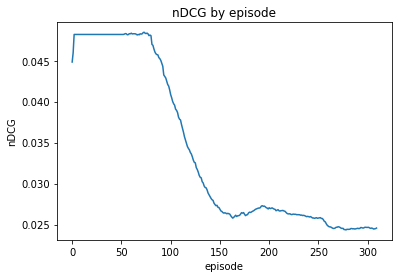

In [50]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(dcgs_all)), dcgs_all)
plt.title('nDCG by episode')
plt.xlabel('episode')
plt.ylabel('nDCG')

Text(0, 0.5, 'MAA')

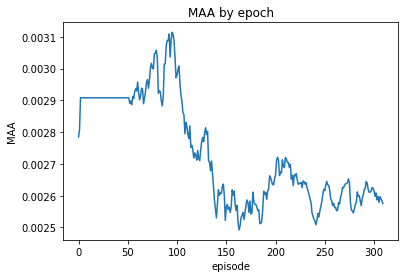

In [52]:
plt.plot(np.arange(len(maa_all)), maa_all)
plt.title('MAA by epoch')
plt.xlabel('episode')
plt.ylabel('MAA')